In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

import json
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
import matplotlib.pyplot as plt

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
dataset_dir='/Disk4/xkp/dataset/iwilddata'
root_dir='/Disk4/xkp/project/iwild'
train_images_dir=dataset_dir+'/train_images'
train_csv_path=dataset_dir+'/train.csv'
test_images_dir=dataset_dir+'/test_images'
test_csv_path=dataset_dir+'/test.csv'
train_l=os.listdir(train_images_dir)
print(len(train_l))
train_df = pd.read_csv(train_csv_path,dtype = {'category_id': str})
print(train_df.shape)

test_l=os.listdir(test_images_dir)
print(len(test_l))
test_df = pd.read_csv(test_csv_path)
print(test_df.shape)

196086
(196299, 11)
153730
(153730, 10)


int64


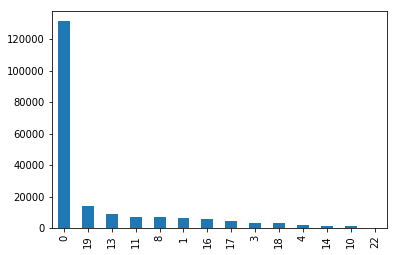

In [3]:
train_df.describe()
import matplotlib.pyplot as plt
train_df['category_id'] = train_df['category_id'].astype(str)
h=train_df['category_id'].value_counts()

print(h.dtypes)

h.plot(kind='bar')

## This is distribuation of classes for trainset
### the train.csv contain (196299, 11) 
### the train_images contain 196086 images


In [4]:
test_df.head()
test_df.describe()

# h_t=test_df['category_id'].value_counts()
# print(h_t.dtypes)
# h_t.plot(kind='bar')

frame_num       location  seq_num_frames     width         height
count  153730.000000  153730.000000   153730.000000  153730.0  153730.000000
mean        5.104703      49.227685        9.195915    1024.0     586.839856
std         6.441114      27.700477       10.155779       0.0      64.423581
min         1.000000       0.000000        1.000000    1024.0     544.000000
25%         1.000000      24.000000        3.000000    1024.0     544.000000
50%         3.000000      50.000000        6.000000    1024.0     544.000000
75%         6.000000      74.000000       12.000000    1024.0     645.000000
max        95.000000      99.000000       95.000000    1024.0     726.000000

In [5]:
train_df.head()
train_df.describe()

frame_num      location  seq_num_frames     width         height
count  196299.000000  196299.00000   196299.000000  196299.0  196299.000000
mean        1.404047      65.83003        1.793494    1024.0     747.486600
std         0.739637      34.35272        1.026838       0.0       3.128948
min         1.000000       0.00000        1.000000    1024.0     747.000000
25%         1.000000      30.00000        1.000000    1024.0     747.000000
50%         1.000000      70.00000        1.000000    1024.0     747.000000
75%         2.000000      96.00000        3.000000    1024.0     747.000000
max         5.000000     138.00000        5.000000    1024.0     768.000000

In [6]:
img_h,img_w=762//2,1024//2
batch_size=16
datagen = ImageDataGenerator(
#     zca_whitening=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1.0/255.0,
    preprocessing_function=None,
    validation_split=0.1)

train_gen=datagen.flow_from_dataframe(
        dataframe = train_df,        
        directory = train_images_dir,
        x_col = 'file_name', y_col = 'category_id',
        target_size=(img_h,img_w),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
val_gen=datagen.flow_from_dataframe(
        dataframe = train_df,        
        directory = train_images_dir,
        x_col = 'file_name', y_col = 'category_id',
        target_size=(img_h,img_w),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')


Found 176478 images belonging to 14 classes.
Found 19608 images belonging to 14 classes.


In [7]:
set(train_gen.class_indices)

{'0', '1', '10', '11', '13', '14', '16', '17', '18', '19', '22', '3', '4', '8'}

In [8]:
nb_classes = 14

In [9]:
from keras.applications.xception import Xception
from keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger

In [ ]:
modelname='Xception'
modeldir=os.path.join(root_dir,modelname)

In [10]:
xception_model=Xception(include_top=False,
                  weights='imagenet', 
                  input_tensor=None, 
                  input_shape=(img_h,img_w,3),
                  pooling='max',
                  classes=1000)
xception_model.trainable=False

In [11]:
# # if not os.path.exists('cooper_xkp'):
# #     os.mkdir('cooper_xkp/')
# print(os.listdir('cooper_xkp/'))

# with open('cooper_xkp/test.txt','w') as f:
#     f.writelines('fasdfadfasdfasfdasfdadf')
# with open('cooper_xkp/test.txt','r') as f:
#     for line in f:
#         print(line)

In [13]:
model=Sequential()
model.add(xception_model)
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu',name='dense2048-512'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu',name='dense512-128'))
model.add(Dense(nb_classes,activation='softmax',name='out'))
sgd=SGD(lr=0.001,decay=1e-4,momentum=0.9,nesterov=True)
from keras.optimizers import Adam
adam=Adam(lr=0.001,decay=0.0001)
log_dir='log'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
modelcheck=ModelCheckpoint(filepath=modeldir+'/best-model.hdf5',monitor='val_loss',save_best_only=True,save_weights_only=True)
csvlog=CSVLogger(filename=modeldir+'/csv_path.csv',separator=',',append=True)
earstop=EarlyStopping(patience=15,monitor='val_loss')



In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense2048-512 (Dense)        (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense512-128 (Dense)         (None, 128)               65664     
_________________________________________________________________
out (Dense)                  (None, 14)                1806      
Total params: 21,978,038
Trainable params: 1,116,558
Non-trainable params: 20,861,480
________________________________________________________

In [15]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
from keras.losses import categorical_crossentropy

model.compile(loss=categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy',f1])


In [17]:
%%time
# Train model
nb_epochs=50
model.load_weights(log_dir+'/best-model.hdf5')
print('---model weights load successfull---')
history = model.fit_generator(
            train_gen,
            steps_per_epoch = (train_gen.samples // batch_size)//10,
#           steps_per_epoch = 100,
            validation_data = val_gen, 
            validation_steps = (val_gen.samples // batch_size)//200,
#           validation_steps = 50,
            epochs = nb_epochs,
            callbacks=[modelcheck,csvlog,earstop],
            verbose=1)

---model weights load successfull---
Epoch 1/50
1102/1102 [==============================] - 991s 899ms/step - loss: 1.0650 - acc: 0.7122 - f1: 0.7086 - val_loss: 1.3233 - val_acc: 0.6875 - val_f1: 0.6898
Epoch 2/50
1102/1102 [==============================] - 986s 895ms/step - loss: 1.0383 - acc: 0.7141 - f1: 0.7138 - val_loss: 1.2649 - val_acc: 0.7292 - val_f1: 0.7267
Epoch 3/50
1102/1102 [==============================] - 979s 889ms/step - loss: 1.0125 - acc: 0.7191 - f1: 0.7155 - val_loss: 0.9892 - val_acc: 0.7708 - val_f1: 0.7908
Epoch 4/50
1102/1102 [==============================] - 973s 883ms/step - loss: 0.9838 - acc: 0.7220 - f1: 0.7240 - val_loss: 1.2112 - val_acc: 0.7083 - val_f1: 0.7104
Epoch 5/50
1102/1102 [==============================] - 972s 882ms/step - loss: 0.9548 - acc: 0.7311 - f1: 0.7322 - val_loss: 1.2483 - val_acc: 0.6771 - val_f1: 0.6638
Epoch 6/50
1102/1102 [==============================] - 981s 890ms/step - loss: 0.9562 - acc: 0.7273 - f1: 0.7310 - val_los

In [69]:
%%time
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe = test_df,        
        directory = test_images_dir,
        x_col = 'file_name', y_col = None,
        target_size = (img_h,img_w),
        batch_size = 10,
        shuffle = False,
        class_mode = None
        )


Found 153730 images.
CPU times: user 683 ms, sys: 324 ms, total: 1.01 s
Wall time: 1.26 s


In [ ]:
%%time
test_generator.reset()
predict = model.predict_generator(test_generator, steps = len(test_generator.filenames)/10,verbose=1)


  338/15373 [..............................] - ETA: 1:31:25

In [ ]:
predicted_class_indices=np.argmax(predict,axis=1)

In [ ]:
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]


In [ ]:
sam_sub_df = pd.read_csv(dataset_dir+'/sample_submission.csv')
print(sam_sub_df.shape)
sam_sub_df.head()

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Id":filenames,
                      "Predicted":predictions})
s=time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime()) 
results['Id'] = results['Id'].map(lambda x: str(x)[:-4])
results.to_csv(model_dir+'/'+s+"results.csv",index=False)